In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from matplotlib import pyplot as plt
import pandas as pd

from keras.models import Sequential                # creating sequential model of CNN
from keras.layers import Conv2D             # creating convolution layer
from keras.layers import MaxPooling2D              # creating maxpool layer
from keras.layers import Flatten                   # creating input vector for dense layer
from keras.layers import Dense                     # create dense layer or fully connected layer
from keras.layers import Dropout                   # use to avoid overfitting by droping some params
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/TF/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Handle the images

In [2]:
img_size = 150, 150
image_tr_names = []
data_tr_labels = []
data_tr_images = []

train_dir = 'cat-and-dog/training_set/training_set'

for folder in os.listdir(train_dir):
    if folder != '.DS_Store':
        for file in os.listdir(os.path.join(train_dir,folder)):
            if file.endswith("jpg"):
                image_tr_names.append(os.path.join(train_dir,folder,file))
                data_tr_labels.append(folder)
                img = cv2.imread(os.path.join(train_dir,folder,file))
                im = cv2.resize(img,img_size)
                data_tr_images.append(im)

In [3]:
image_te_names = []
data_te_labels = []
data_te_images = []

test_dir = 'cat-and-dog/test_set/test_set'

for folder in os.listdir(test_dir):
    if folder != '.DS_Store':
        for file in os.listdir(os.path.join(test_dir,folder)):
            if file.endswith("jpg"):
                image_te_names.append(os.path.join(test_dir,folder,file))
                data_te_labels.append(folder)
                img = cv2.imread(os.path.join(test_dir,folder,file))
                im = cv2.resize(img,img_size)
                data_te_images.append(im)

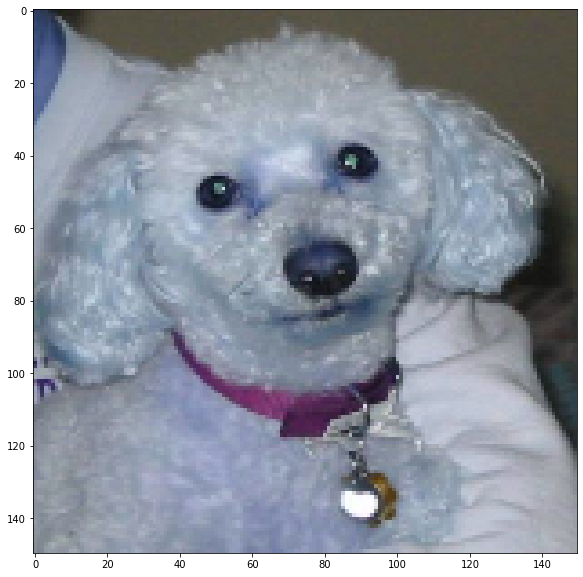

In [4]:
fig = plt.figure(figsize=(10,10))
plt.imshow(data_tr_images[2])
plt.show()

In [5]:
# checks

data_X_tr_va = np.array(data_tr_images)
data_y_tr_va = np.array(data_tr_labels)
print("image number for cats in train set",np.count_nonzero(data_y_tr_va=='cats'))
print("image number for dogs in train set",np.count_nonzero(data_y_tr_va=='dogs'))

data_X_te = np.array(data_te_images)
data_y_te = np.array(data_te_labels)
print("image number for cats in test set",np.count_nonzero(data_y_te=='cats'))
print("image number for dogs in test set",np.count_nonzero(data_y_te=='dogs'))

image number for cats in train set 4000
image number for dogs in train set 4005
image number for cats in test set 1011
image number for dogs in test set 1012


In [6]:
# cats=0 dogs=1

data_y_tr_va[data_y_tr_va=='dogs'] = 1
data_y_tr_va[data_y_tr_va=='cats'] = 0
data_y_te[data_y_te=='dogs'] = 1
data_y_te[data_y_te=='cats'] = 0

# array([1, 2, 2]) = [int(numeric_string) for numeric_string in data_y_te]

In [7]:
data_y_te = data_y_te.astype(int)
data_y_tr_va = data_y_tr_va.astype(int)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(test_size=0.15, random_state=42)
train_idx = None
valid_idx = None

for tr_idx, va_idx in strat_split.split(data_X_tr_va,data_y_tr_va):
    valid_idx = va_idx
    train_idx = tr_idx

data_X_tr = data_X_tr_va[train_idx]
data_y_tr = data_y_tr_va[train_idx]
data_X_va = data_X_tr_va[valid_idx]
data_y_va = data_y_tr_va[valid_idx]





print("X_train shape",data_X_tr.shape)
print("X_val shape",data_X_va.shape)
print("y_train shape",data_y_tr.shape)
print("y_val shape",data_y_va.shape)
np.count_nonzero(data_y_tr==0)

X_train shape (6804, 150, 150, 3)
X_val shape (1201, 150, 150, 3)
y_train shape (6804,)
y_val shape (1201,)


3400

In [9]:
data_X_tr = data_X_tr/255
data_X_va = data_X_va/255
data_X_te = data_X_te/255

# Build cNN model

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

classifier = Sequential([
        Conv2D(15, (3, 3), input_shape = (img_size[0],img_size[1], 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(15, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.4),
#         Conv2D(5, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
#         MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.3),
#         Conv2D(10, 10, 3, activation = 'elu',kernel_initializer="he_normal"),
#         MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Flatten(),
        BatchNormalization(),
        Dense(output_dim= 100, activation="elu",kernel_initializer="he_normal"),
        BatchNormalization(),
#         Dense(output_dim= 100, activation="elu",kernel_initializer="he_normal"),
#         BatchNormalization(),
        Dense(output_dim= 1, activation='sigmoid',kernel_initializer="glorot_normal")
])

classifier.summary()


In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

scheduler_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(optimizer= optimizer, loss= 'binary_crossentropy', metrics= ['accuracy'])
classifier.summary()

In [ ]:
patience = 25
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,restore_best_weights=True)

In [75]:
history = classifier.fit(data_X_tr,data_y_tr,epochs=100,validation_data=(data_X_va, data_y_va),
                    batch_size=1000,callbacks=[early_stopping_cb])

Train on 6804 samples, validate on 1201 samples
Epoch 1/100
6804/6804 [==============================] - 11s 2ms/step - loss: 0.8309 - accuracy: 0.5550 - val_loss: 0.8733 - val_accuracy: 0.5037
Epoch 2/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.7363 - accuracy: 0.6080 - val_loss: 1.4259 - val_accuracy: 0.5004
Epoch 3/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.6861 - accuracy: 0.6362 - val_loss: 0.7077 - val_accuracy: 0.5853
Epoch 4/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.6481 - accuracy: 0.6584 - val_loss: 0.8121 - val_accuracy: 0.5470
Epoch 5/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.6325 - accuracy: 0.6626 - val_loss: 0.6789 - val_accuracy: 0.6095
Epoch 6/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.6083 - accuracy: 0.6745 - val_loss: 0.6497 - val_accuracy: 0.6187
Epoch 7/100
6804/6804 [==============================] - 9s 1ms/step - loss: 0.58

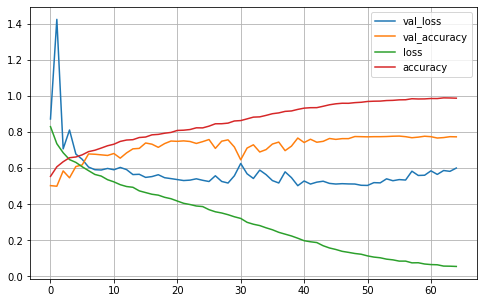

In [76]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1000)
plt.show()

In [77]:
from sklearn.metrics import roc_auc_score


y_pred_proba_test = classifier.predict(data_X_te)
y_pred_test = classifier.predict_classes(data_X_te)
# y_pred_proba_train = model.predict(df_X_train)
# y_pred_proba_valid = model.predict(df_X_valid)

# print("AUC socre train:", roc_auc_score(df_y_train,y_pred_proba_train))
# print("AUC socre valid:", roc_auc_score(df_y_valid,y_pred_proba_valid))
print("AUC socre test:", roc_auc_score(data_y_te,y_pred_proba_test))


AUC socre test: 0.8334252080865421


In [78]:
from sklearn.metrics import accuracy_score

accuracy_score(data_y_te,y_pred_test)

0.7449332674246169

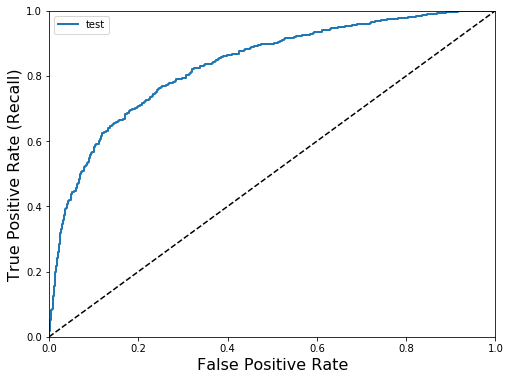

In [79]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.legend()



# fpr_train, tpr_train, thresholds_train = roc_curve(df_y_train, y_pred_proba_train)
# fpr_valid, tpr_valid, thresholds_valid = roc_curve(df_y_valid, y_pred_proba_valid)

fpr_test, tpr_test, thresholds_test = roc_curve(data_y_te, y_pred_proba_test[:,0])

plt.figure(figsize=(8, 6))
# plot_roc_curve(fpr_train, tpr_train,'train')
# plot_roc_curve(fpr_valid, tpr_valid, 'valid')
plot_roc_curve(fpr_test, tpr_test, 'test')
plt.show()

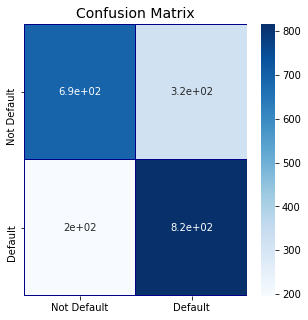

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(data_y_te, y_pred_test)
# cm = confusion_matrix(df_y_train, RF_clf_proba[:,1]>=0.5)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

array([[0]], dtype=int32)

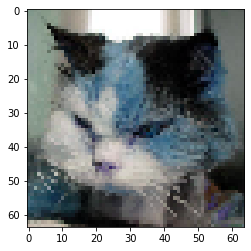

In [88]:
im_try_list=[]
imgtry = cv2.imread('cattest.jpg')
# imgtry.shape
im_try = cv2.resize(imgtry,img_size)

im_try = data_X_te[1700]
plt.figure()
plt.imshow(im_try)
im_try_list.append(im_try)
im_ls = np.array(im_try_list)

# classifier.predict_classes(np.array([data_tr_images[2]]))
classifier.predict_classes(im_ls)

## Another model using keras image generator for data augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = 'cat-and-dog/training_set/training_set'
test_dir = 'cat-and-dog/test_set/test_set'


train_gen = ImageDataGenerator(rescale=1.0/255.0,
                              shear_range=0.2,
                              zoom_range=0.2,
                              rotation_range=45, #Int. Degree range for random rotations.
                              width_shift_range=0.2, #fraction of total width
                              height_shift_range=0.2,#fraction of total height
                              horizontal_flip=True)
# do rescaling, random shearing, zoom and horizontal flipping to training images

test_gen = ImageDataGenerator(rescale = 1./255.0) # do only rescaling to test images

imgsize = 150

X_train = train_gen.flow_from_directory(train_dir,
                                          target_size = (imgsize,imgsize),
                                          batch_size = 32,
                                          class_mode = 'binary') # For train data, select directory, sizes and import
X_test = test_gen.flow_from_directory(test_dir,
                                         target_size = (imgsize,imgsize),
                                         batch_size = 32,
                                         class_mode = 'binary')

Found 8006 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


Found 8006 images belonging to 2 classes.


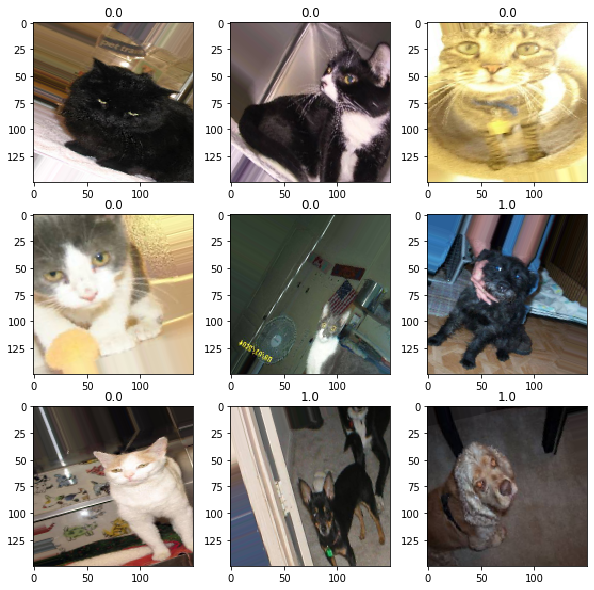

In [11]:
for X_batch,y_batch in train_gen.flow_from_directory(train_dir,
                                          target_size = (imgsize,imgsize),
                                          batch_size = 9,
                                          class_mode = 'binary'): # For train data, select directory, sizes and import
    # create a grid of 3x3 images
    plt.figure(figsize=(10,10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(imgsize, imgsize,3), cmap=plt.get_cmap('gray'))
        plt.title(str(y_batch[i]))
    # show the plot
    plt.show()
    break

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

classifier = Sequential([
        Conv2D(32, (3, 3), input_shape = (imgsize,imgsize,3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'elu',kernel_initializer="he_uniform"),
        MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.3),
#         Conv2D(128, (3, 3), activation = 'elu',kernel_initializer="he_normal"),
#         MaxPooling2D(pool_size=(2,2)),
#         Dropout(0.2),
        Flatten(),
        BatchNormalization(),
        Dense(output_dim= 512, activation="elu",kernel_initializer="he_normal"),
        BatchNormalization(),
#         Dense(output_dim= 100, activation="elu",kernel_initializer="he_normal"),
#         BatchNormalization(),
        Dense(output_dim= 1, activation='sigmoid',kernel_initializer="glorot_normal")
])

classifier.summary()


/opt/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="elu", kernel_initializer="he_normal", units=512)`
/opt/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", kernel_initializer="glorot_normal", units=1)`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [13]:
optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(optimizer= 'Adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [14]:
patience = 30
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=patience,restore_best_weights=True)

In [15]:
history = classifier.fit_generator(X_train, epochs=150, validation_data=X_test,callbacks =[early_stopping_cb])        

Epoch 1/150
251/251 [==============================] - 158s 631ms/step - loss: 0.8379 - accuracy: 0.5938 - val_loss: 0.5371 - val_accuracy: 0.5907
Epoch 2/150
251/251 [==============================] - 158s 631ms/step - loss: 0.6523 - accuracy: 0.6351 - val_loss: 0.6239 - val_accuracy: 0.5413
Epoch 3/150
251/251 [==============================] - 158s 630ms/step - loss: 0.6361 - accuracy: 0.6524 - val_loss: 0.9100 - val_accuracy: 0.5828
Epoch 4/150
251/251 [==============================] - 152s 607ms/step - loss: 0.6070 - accuracy: 0.6720 - val_loss: 0.9939 - val_accuracy: 0.6164
Epoch 5/150
251/251 [==============================] - 144s 574ms/step - loss: 0.5943 - accuracy: 0.6799 - val_loss: 0.6032 - val_accuracy: 0.7286
Epoch 6/150
251/251 [==============================] - 140s 558ms/step - loss: 0.5814 - accuracy: 0.6926 - val_loss: 0.8499 - val_accuracy: 0.7153
Epoch 7/150
251/251 [==============================] - 149s 592ms/step - loss: 0.5696 - accuracy: 0.7041 - val_loss: 0

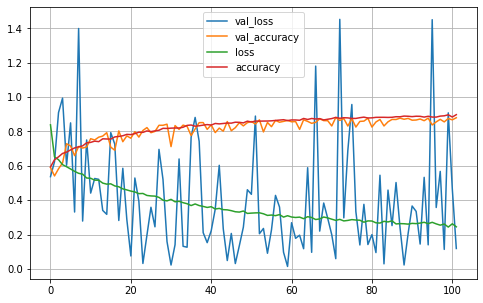

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1000)
plt.show()

In [20]:
X_test_check = test_gen.flow_from_directory(test_dir,
                                         target_size = (imgsize,imgsize),
                                         batch_size = 32,
                                         shuffle = False,
                                         class_mode = 'binary')

Found 2023 images belonging to 2 classes.


In [26]:
from sklearn.metrics import roc_auc_score

y_true_test = X_test_check.classes
y_pred_proba_test = classifier.predict_generator(X_test_check)

print("AUC socre test:", roc_auc_score(y_true_test,y_pred_proba_test))
print("accutacy score:", accuracy_score(y_true_test,y_pred_proba_test>=0.5))


AUC socre test: 0.9527304394740854
accutacy score: 0.8808699950568463


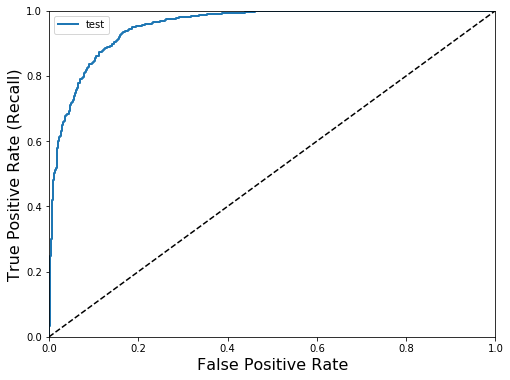

In [22]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.legend()

fpr_test, tpr_test, thresholds_test = roc_curve(y_true_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_test, tpr_test, 'test')
plt.show()

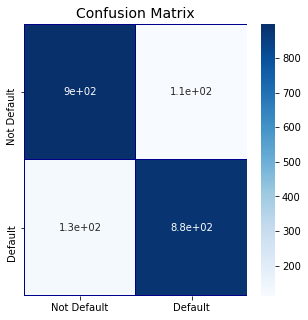

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true_test, y_pred_proba_test>=0.5)
# cm = confusion_matrix(df_y_train, RF_clf_proba[:,1]>=0.5)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

AUC socre test: 0.9175394768221501
accutacy score: 0.8185862580326249


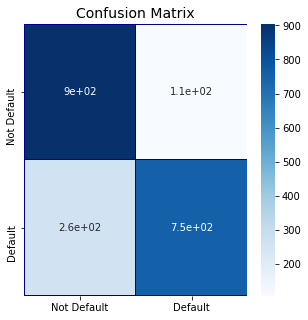

In [24]:
from sklearn.metrics import accuracy_score


y_pred_proba_test = classifier.predict(data_X_te)
y_pred_test = classifier.predict_classes(data_X_te)

print("AUC socre test:", roc_auc_score(data_y_te,y_pred_proba_test))
print("accutacy score:", accuracy_score(data_y_te,y_pred_test))

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(data_y_te, y_pred_proba_test>=0.5)
# cm = confusion_matrix(df_y_train, RF_clf_proba[:,1]>=0.5)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()


In [46]:
import numpy as np
from keras.preprocessing import image


test_image=image.load_img('IMG_7552.jpg',target_size=(150,150))

test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)



result=classifier.predict_classes(test_image/255.)

if result[0][0] >=0.5:
    prediction='dog'
else:
    prediction='cat'
print(prediction)


dog
